# Titanic Classification Continued
## Ernesto Gonzales, MSDA
### Learning Goals:
### 1. Adding more features from the dataset.
### 2. Using cross-validation for more reliable evaluation.
### 3. Visualizing a ROC curve to understand threshold trade-offs.


In [3]:
# Importing libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay)


In [9]:
# Loading Titanic Dataset (seaborn)
df = sns.load_dataset("titanic")

# Adding features
features = ["sex", "age", "fare", "class", "embarked", "sibsp", "parch", "alone"]
X = df[features].copy()
y = df["survived"].copy()

# Dropping rows with NA in features
X = X.dropna()
y = y.loc[X.index]

# Quick data check

print("X shape:", X.shape, " | y shape:", y.shape)
display(X.head())
display(y.head())


X shape: (712, 8)  | y shape: (712,)


,sex,age,fare,class,embarked,sibsp,parch,alone
0,male,22.0,7.2500,Third,S,1,0,False
1,female,38.0,71.2833,First,C,1,0,False
2,female,26.0,7.9250,Third,S,0,0,True
3,female,35.0,53.1000,First,S,1,0,False
4,male,35.0,8.0500,Third,S,0,0,True


0    0
1    1
2    1
3    1
4    0
Name: survived, dtype: int64

In [14]:
# Separate numeric and categorical features

num_features = ["age", "fare", "sibsp", "parch"]
cat_features = ["sex", "class", "embarked", "alone"]

# Transformers for each type

num_transformer = Pipeline(steps=[("scaler", StandardScaler())])
cat_transformer = Pipeline(steps=[("encoder", OneHotEncoder(handle_unknown="ignore"))])

# Combining preprocessing

preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_features), ("cat", cat_transformer, cat_features)])

# Full pipeline preprocessing + Logistic Regression
clf = Pipeline(steps=[("preprocesssor", preprocessor),
                      ("model", LogisticRegression(max_iter=1000, class_weight="balanced"))])

In [16]:
# Cross-validation

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Accuracy across folds
acc_scores = cross_val_score(clf, X, y, cv=cv, scoring="accuracy")

# F1 across folds - harmonic mean
f1_scores = cross_val_score(clf, X, y, cv=cv, scoring="f1")

# ROC-AUC across folds

roc_scores = cross_val_score(clf, X,y, cv=cv, scoring="roc_auc")

cv_results = pd.DataFrame({
    "Metric": ["Accuracy", "F1", "ROC-AUC"],
    "Mean": [acc_scores.mean(), f1_scores.mean(), roc_scores.mean()],
    "Std": [acc_scores.std(), f1_scores.std(), roc_scores.std()]})

print("Fold scores (Accuracy):", np.round(acc_scores, 4))
print("Fold scores (F1): ", np.round(f1_scores,4))
print("Fold scores (ROC-AUC): " , np.round(roc_scores, 4))

cv_results



Fold scores (Accuracy): [0.8322 0.8112 0.7746 0.7887 0.7817]
Fold scores (F1):  [0.7931 0.7477 0.7333 0.7458 0.7597]
Fold scores (ROC-AUC):  [0.8876 0.8541 0.8169 0.8213 0.8814]


,Metric,Mean,Std
0,Accuracy,0.797685,0.021157
1,F1,0.755911,0.020388
2,ROC-AUC,0.852246,0.029362


<Figure size 600x500 with 0 Axes>

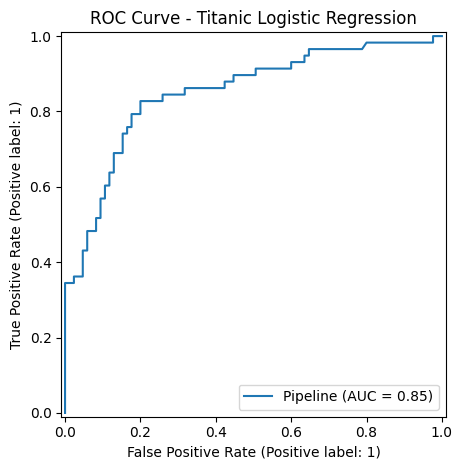

In [21]:
# Ploting ROC Curve

# Creating splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Fit pipeline on training set
clf.fit(X_train, y_train)

# Ploting ROC curve
plt.figure(figsize=(6,5))
RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.title("ROC Curve - Titanic Logistic Regression")
plt.tight_layout()
plt.show()

In [22]:
import os
os.makedirs("../docs", exist_ok=True)

# Saving ROC figure
plt.savefig("../docs/titanic_roc_curve.png", dpi=150, bbox_inches="tight")


<Figure size 640x480 with 0 Axes>

In [28]:
cv_md_path = "../docs/titanic_cv_results.md"

with open(cv_md_path, "w", encoding="utf-8") as f:
    f.write("# Titanic Logistic Regression - Cross-validation Results\n\n")
    f.write(cv_results.to_markdown(index=False, floatfmt=".4f"))
print(f"Saved CV results: {cv_md_path}")

Saved CV results: ../docs/titanic_cv_results.md


In [31]:
# Adding a README
summary_path = "../docs/README.md"
summary = """# Day 3 - Titanic Logistic Regression (CV + ROC)

Artifacts:
- 'titanic_cv_results.md' - 5-fold CV (Accuracy, F1, ROC-AUC)
- 'titanic_roc_curve.png' - ROC curve on holdout test

Notes:
- Used 'class_weight="balanced"' for class imbalance.
- Cross-validation with 'StratifiedKfolds(n_splits=5)'.
- Features: sex, age, fare, class, embarked, sibsp, parch, alone.
"""
with open(summary_path, "w", encoding="utf-8") as f:
    f.write(summary)
print(f"Wrote summary: {summary_path}")

Wrote summary: ../docs/README.md
